* In this section, we take a deep dive into details of **backward propagation** also known as **backpropagation**.

## 1.1 Forward Propagation.

* **forward propagation** is the calculation and storage of intermediate variables for a neural network in order from the input layer to the output layer.

* Let's assume that the input example is **x** and that our hidden layers does not include a bias term.
* Here the intermediate variable is:
  $z = W^{(1)}x$.
* Here  $ W^{(1)}$ is the weight parameter of the hidden layer.

In [14]:
import torch

In [15]:
y = torch.randn(4,4)

In [16]:
x = torch.rand(3,4,requires_grad=True)
w_1 = torch.rand(4,3,requires_grad=True)
z = torch.matmul(w_1,x)
z

tensor([[0.3206, 0.7111, 0.4913, 0.4429],
        [0.8187, 1.4006, 0.9113, 1.1031],
        [0.4330, 0.3157, 0.2539, 0.3526],
        [0.9858, 1.2758, 0.9573, 0.9735]], grad_fn=<MmBackward0>)

* After running intermiadiate variable $z$ through activation function $Φ$ we obtain our hidden activation vector of length $h$:

$h = Φ (z)$.

In [17]:
def relu(X):
  return torch.max(torch.tensor(0.0),X)

In [18]:
h = relu(z)
h

tensor([[0.3206, 0.7111, 0.4913, 0.4429],
        [0.8187, 1.4006, 0.9113, 1.1031],
        [0.4330, 0.3157, 0.2539, 0.3526],
        [0.9858, 1.2758, 0.9573, 0.9735]], grad_fn=<MaximumBackward0>)

* The hidden layer output $h$ is also an intermediate variable.
* Assumng that the parameters of the output layer posses only weight of $ W^{(2)}$, we can obtain an output layer variable with a vector of length q:
   
   $
   o =  W^{(2)} h
   $

In [19]:
w_2 = torch.rand(4,4,requires_grad=True)
o = torch.matmul(w_2,h)
o

tensor([[1.9489, 2.8558, 1.9930, 2.2344],
        [0.6234, 0.8544, 0.6264, 0.6488],
        [1.7671, 2.6867, 1.8752, 2.0527],
        [1.1917, 2.0141, 1.3648, 1.5079]], grad_fn=<MmBackward0>)

* Assuming the loss function $l$ and the example label is $y$, we can can calculate the loss term for a single data example:
  $L = l(o,y)$

In [20]:
def loss(y_true,y_hat):
  ##ensuring values of y_hat are positive for log
  #y_hat_clipped = torch.clamp(y_hat,min=1e-8) #avoids log(0)
  return 0.5*torch.mean((y_hat-y_true)**2)

In [21]:
L=loss(y,o)
L

tensor(2.5880, grad_fn=<MulBackward0>)

* Given the hyperparameter $λ$, the regularization term is:
  
  $s = \frac{\lambda}{2} \left( \|W^{(1)}\|_F^2 + \|W^{(2)}\|_F^2 \right)$

* where the Frobenius norm of a matrix is simply the $l_2$.
* Finally, the model's regularized loss on a given data example is:
  $J = L + s$
* We refer to $J$ as the $objective function$.

In [22]:
##regularization term
lambda_ = 0.1
s = lambda_*0.5*(torch.norm(w_1,p='fro') + torch.norm(w_2,p='fro'))
s

tensor(0.2149, grad_fn=<MulBackward0>)

In [23]:
##objective function
J =L + s
J

tensor(2.8030, grad_fn=<AddBackward0>)

## 2 Computational Graph of Forward Propagation


# Task
Install `torchviz`, re-initialize the tensors `x`, `w_1`, and `w_2` with `requires_grad=True`, and then re-run the forward propagation to ensure the computation graph is traceable. Finally, use `torchviz.make_dot` to plot the computational graph of the objective function `J`.

## Install torchviz

### Subtask:
Install the torchviz library for visualizing PyTorch computation graphs.


**Reasoning**:
To install the `torchviz` library as per the instructions, I will use `!pip install torchviz` in a code cell.



In [13]:
get_ipython().system('pip install torchviz')

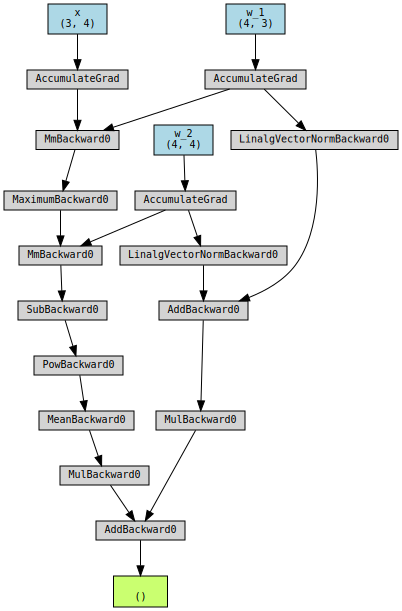

In [24]:
from torchviz import make_dot

# Plot the computational graph of J
graph = make_dot(J, params={'x': x, 'w_1': w_1, 'w_2': w_2,})
graph

## 3 BackPropagation

* Backprogation referes to the method of calculating the gradients of neural networks parameters.
* This method transverses the network transverses the network in reverse order, from output to the input layer, according the **chain rule** from calculus.
* The algorithm stores any intermediate variables required while calculating the gradient with respect to some parameters.
* Assume that we have functions $Y=f(x)$ and $Z=g(x)$, in which the input and output X,Y,Z are tensors of random shapes.
* By using chain rule,we can compute the derivative of $Z$ with respect to $X$ via:
  $\frac{\partial Z}{\partial X} = \frac{\partial Z}{\partial Y} \frac{\partial Y}{\partial X}$

* Here we use the prod operator to multiply its arguments after necessary operations.
* Recall that the parameters of the simple forward pass we previously attempted,its parameters are $W^{(1)}$ and $W^{(2)}$.
* The objective of backpropagation is to calculate the gradients $\frac{\partial J}{\partial W^{(1)}} \quad \text{and} \quad \frac{\partial J}{\partial W^{(2)}}$.
* To accomplish this, we apply chain rule and calculate,in turn the gradients of each intermediate variable and parameter.
* First we calculate the gradient of the objective function $J=L+s$ with respect to the loss term $L$ and the regularization term $S$:
  $\frac{\partial J}{\partial L} = 1 \quad \text{and} \quad \frac{\partial J}{\partial s} = 1$
  


In [25]:
dj_dl =1
dj_ds = 1


* Next we compute the gradient of the objective function with respect to  variable of the output layer $o$ according to chain rule:
  $\frac{\partial J}{\partial o} = \frac{\partial J}{\partial L} \frac{\partial L}{\partial o} = \frac{\partial L}{\partial o} \in \mathbb{R}^q$

In [26]:
N = o.numel()

In [27]:
dl_do = ((o-y)*2)/N
dl_do

tensor([[ 0.2160,  0.2652,  0.3968,  0.3439],
        [ 0.0698, -0.0016,  0.1421,  0.0833],
        [ 0.3821,  0.3704,  0.2947,  0.1156],
        [ 0.3585,  0.4021,  0.4179,  0.1451]], grad_fn=<DivBackward0>)

In [28]:
dj_do = dj_dl*dl_do
dj_do

tensor([[ 0.2160,  0.2652,  0.3968,  0.3439],
        [ 0.0698, -0.0016,  0.1421,  0.0833],
        [ 0.3821,  0.3704,  0.2947,  0.1156],
        [ 0.3585,  0.4021,  0.4179,  0.1451]], grad_fn=<MulBackward0>)

* Next we calculate the gradients of the regularization term with respect to both parameters:  
  $\frac{\partial s}{\partial W^{(1)}} = \lambda W^{(1)} \quad \text{and} \quad \frac{\partial s}{\partial W^{(2)}} = \lambda W^{(2)}$

In [29]:
ds_dw1 = lambda_*w_1
ds_dw2 = lambda_*w_2
ds_dw1,ds_dw2

(tensor([[0.0314, 0.0596, 0.0075],
         [0.0277, 0.0951, 0.0640],
         [0.0290, 0.0036, 0.0223],
         [0.0915, 0.0770, 0.0285]], grad_fn=<MulBackward0>),
 tensor([[0.0531, 0.0993, 0.0663, 0.0689],
         [0.0410, 0.0021, 0.0331, 0.0336],
         [0.0760, 0.0832, 0.0446, 0.0658],
         [0.0816, 0.0828, 0.0214, 0.0162]], grad_fn=<MulBackward0>))

* Now we are able to calculate the gradient $\frac{\partial J}{\partial W^{(2)}} $ of the model parameters closest to the output layer. Using chain rule yields:
  $\frac{\partial J}{\partial W^{(2)}} = \frac{\partial J}{\partial o} \frac{\partial o}{\partial W^{(2)}} + \frac{\partial J}{\partial s} \frac{\partial s}{\partial W^{(2)}} = \frac{\partial L}{\partial o} h^\top + \lambda W^{(2)}$

In [30]:
dj_dw2 = dj_do*h.T + lambda_*w_2
dj_dw2

tensor([[ 1.2229e-01,  3.1636e-01,  2.3814e-01,  4.0787e-01],
        [ 9.0606e-02, -2.6187e-05,  7.7967e-02,  1.3993e-01],
        [ 2.6377e-01,  4.2071e-01,  1.1947e-01,  1.7650e-01],
        [ 2.4034e-01,  5.2645e-01,  1.6878e-01,  1.5738e-01]],
       grad_fn=<AddBackward0>)

* To obtain the gradients with respect to $W^{(1)}$ we need to continue backpropagation along the output layer to hidden layer.
* The gradient with respect to hidden layer output $\frac{\partial J}{\partial h} \in \mathbb{R}^h$ is given by.
  $\frac{\partial J}{\partial h} = \frac{\partial J}{\partial o} \frac{\partial o}{\partial h} = (W^{(2)})^\top \frac{\partial J}{\partial o}$



In [31]:
dj_dh = torch.matmul(w_2.T,dj_do)
dj_dh

tensor([[0.7261, 0.7497, 0.8337, 0.4228],
        [0.8307, 0.9044, 0.9883, 0.5595],
        [0.4138, 0.4269, 0.5314, 0.3384],
        [0.4817, 0.4909, 0.5826, 0.3644]], grad_fn=<MmBackward0>)

* Since the activation function $𝛟$ applies elementwise, calculating th gradient $\frac{\partial J}{\partial z} \in \mathbb{R}^h$ of the intermediate variable $z$ requires that we use the elementwise multiplication operator $\odot$.
  $\frac{\partial J}{\partial z} = \frac{\partial J}{\partial h} \odot \frac{\partial h}{\partial z} = \frac{\partial J}{\partial h} \odot \phi'(z)$

In [32]:
dj_dz = dj_dh*relu(z)
dj_dz

tensor([[0.2328, 0.5331, 0.4096, 0.1873],
        [0.6801, 1.2667, 0.9006, 0.6172],
        [0.1792, 0.1348, 0.1349, 0.1193],
        [0.4749, 0.6263, 0.5577, 0.3547]], grad_fn=<MulBackward0>)

* Finally we obtain the gradient $\frac{\partial J}{\partial W^{(1)}} \in \mathbb{R}^{h \times d}$ of the model parameters closest to the input layer.
* According the chain rule we get:
  $\frac{\partial J}{\partial W^{(1)}} = \frac{\partial J}{\partial z} \frac{\partial z}{\partial W^{(1)}} + \frac{\partial J}{\partial s} \frac{\partial s}{\partial W^{(1)}} = \frac{\partial J}{\partial z} x^\top + \lambda W^{(1)}$

In [33]:
dj_dw1 = torch.matmul(dj_dz,x.T) + lambda_*w_1
dj_dw1

tensor([[0.7221, 0.8141, 0.9579],
        [1.8093, 1.9188, 2.5712],
        [0.3436, 0.2402, 0.4565],
        [1.1548, 1.0582, 1.4939]], grad_fn=<AddBackward0>)

## 4 Training Neural Networks

* When training neural networks, forward and backward propagation dependes on each otherr.
* For forward propagation, we transverse the computational graph in the direction of dependecies and compute all the variables on its path.
* When training neural networks, once model parameters are intialized,we alternate forward propagation with backward propagation, updating model parameters using gradients given by backward propagation.